# load SHAP tool 

In [ ]:
pip install shap

#  load tools 

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import shap
# from rdkit import Chem
# from rdkit.Chem.Draw import rdMolDraw2D
from sklearn.pipeline import Pipeline
print(' load ')

 load 


In [2]:

!dir data* 

 Volume in drive C is Aalto HD
 Volume Serial Number is DEE1-D994

 Directory of C:\Users\laasonk1\OneDrive - Aalto University\Documents\python

18/03/2025  17.59    <DIR>          data
02/05/2025  15.20            59ÿ236 data.xlsx
02/05/2025  15.56            70ÿ313 dataset-kaveh.csv
               2 File(s)        129ÿ549 bytes
               1 Dir(s)  136ÿ924ÿ811ÿ264 bytes free
 Volume in drive C is Aalto HD
 Volume Serial Number is DEE1-D994

 Directory of C:\Users\laasonk1\OneDrive - Aalto University\Documents\python

18/03/2025  17.59    <DIR>          data
02/05/2025  15.20            59ÿ236 data.xlsx
02/05/2025  15.56            70ÿ313 dataset-kaveh.csv
               2 File(s)        129ÿ549 bytes
               1 Dir(s)  136ÿ924ÿ811ÿ264 bytes free


Data set from ACS Cat paper: https://doi.org/10.1021/acscatal.4c03368

Target 'ΔΔG' - the energy difference of catalyst binding to O or to C 

Descriptors:
pz_C2_pop : pz population of C2  
px_O_pop  : pz population of O
NBO_C_diazo :  Natural Population Analysis of the diazo C 
NBO_N1   :  NPA of N1
NBO_N2   :  NPA of N2 
NBO_C_carbonyl  : NPA of C
NBO_O   : NPA of O 
HOMO	: HOMO  energy 

483 reactions

In [3]:
data_all = pd.read_csv("dataset-kaveh.csv")
data=data_all.head(2000)       # first 2000, not so good since they are not random
print('full data:', data_all.shape)
print('working data:', data.shape)
# print(data.size)
data

full data: (483, 20)
working data: (483, 20)


,name,pz_C2_pop,px_O_pop,NBO_C_diazo,NBO_N1,NBO_N2,NBO_C_carbonyl,NBO_O,HOMO,ΔG,ΔG_fromAdd,adduct,ΔG-ΔG_O,ΔG_O,ΔG_C_fromDiazo,ΔG_C,ΔG-ΔG_C,BCl3_Role,ΔΔG,Overall performance
0,16_17,1.25984,1.86131,-0.089,0.086,0.080,0.547,-0.599,-7.221,29.64,41.05,-11.41,14.54,15.11,11.40,22.81,6.83,1,7.71,14.54
1,8_19,1.28716,1.80090,-0.140,0.119,0.160,0.631,-0.533,-7.976,30.58,26.02,4.55,14.12,16.46,24.22,24.22,6.36,1,7.76,14.12
2,18_19,1.18824,1.85751,-0.105,0.090,0.089,0.547,-0.595,-7.511,30.79,41.15,-10.36,14.40,16.39,14.84,25.19,5.60,1,8.81,14.40
3,19_4,1.16975,1.86966,0.348,0.005,0.079,0.477,-0.569,-8.086,22.05,30.74,-8.69,-4.31,26.36,9.82,18.50,3.55,1,-7.86,3.55
4,19_8,1.23926,1.85916,0.009,0.091,0.188,0.537,-0.529,-8.665,33.71,35.42,-1.71,-3.02,36.73,27.60,29.31,4.40,1,-7.42,4.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,13_1,1.25261,1.79253,-0.626,0.086,0.062,0.798,-0.360,-8.102,38.63,44.04,-5.41,4.59,34.04,10.57,15.98,22.65,1,-18.06,22.65
479,8_15,1.32023,1.79866,-0.537,0.093,0.127,0.611,0.036,-8.378,7.26,6.56,0.70,6.66,0.60,15.82,15.82,-8.56,1,15.22,6.66
480,4_9,1.37984,1.80452,-0.567,0.124,0.191,0.925,-0.270,-9.040,35.62,30.28,5.34,-8.13,43.76,28.68,28.68,6.94,1,-15.07,6.94
481,12_1,1.32138,1.70549,-0.647,0.083,0.046,0.797,-0.359,-8.060,38.31,42.56,-4.25,-5.44,43.75,8.14,12.39,25.92,1,-31.36,25.92


features : the descriptors

top_features : the most important features (can be known only later) 

In [4]:
features = ['pz_C2_pop', 'px_O_pop', 'NBO_C_diazo', 'NBO_N1', 'NBO_N2', 'NBO_C_carbonyl', 'NBO_O', 'HOMO']
# top_features=['HOMO','NBO_C_diazo','pz_C2_pop','NBO_C_carbonyl']
target = 'ΔΔG'

# X = data[top_features]
X = data[features]
y = data[target]

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
X.columns

Index(['pz_C2_pop', 'px_O_pop', 'NBO_C_diazo', 'NBO_N1', 'NBO_N2',
       'NBO_C_carbonyl', 'NBO_O', 'HOMO'],
      dtype='object')

In [6]:
y

0       7.71
1       7.76
2       8.81
3      -7.86
4      -7.42
       ...  
478   -18.06
479    15.22
480   -15.07
481   -31.36
482   -18.59
Name: ΔΔG, Length: 483, dtype: float64

You can choose some ML method. like RF, KR or GB

In [7]:

ML="RF"

if ML=="GB":
#  # GB method next 2 lines
  model = GradientBoostingRegressor()
  parameters = {'learning_rate': np.arange(0.05, 0.3, 0.05), "loss": ['huber'],"n_estimators": range(20, 80, 10),
                'subsample': [1.0, 0.9]}   # for GB
#parameters = {'learning_rate': np.arange(0.05, 0.3, 0.05), "loss": ['ls', 'huber'], "n_estimators": range(20, 80, 10),
#               'subsample': [1.0, 0.9]}   # for GB
if ML=="KR":
  model = KernelRidge()
  parameters = {"alpha": np.arange(0.5, 3.5, 0.2), "kernel": ['linear', 'polynomial', 'laplacian'], "degree": [2,3]}  #  KRR

if ML=="RF":
# RF methods next 2 lines
  model = RandomForestRegressor()
  parameters = {"n_estimators": range(110, 190, 20), "min_samples_split":[2,3]}  # for RF

# search for best parameters of the ML method (average over 10 times)

clf = GridSearchCV(model, parameters, cv = 10, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')

In [8]:
from time import time

time0=time()
clf.fit(X,y)
timee=time()
print('time used',timee-time0,' s')

Fitting 10 folds for each of 8 candidates, totalling 80 fits
time used 12.597529649734497  s


Above find the best parametes for this data set 

In [9]:
print(clf.best_params_)



{'min_samples_split': 3, 'n_estimators': 130}


In [10]:
model = clf.best_estimator_
print(model)

RandomForestRegressor(min_samples_split=3, n_estimators=130)


Test the quality of the ML with multiple splits


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_mae_list = []
val_mae_list = []

train_r2_list = []
val_r2_list = []

for ii in range(20): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_test, y_test_pred)   

    # Append MAE scores to the lists
    train_mae_list.append(train_mae)
    val_mae_list.append(val_mae)
    train_r2_list.append(train_r2)
    val_r2_list.append(val_r2)
     
    print(ii,'Train R2 ',train_r2,'Test R2 ',val_r2)

avg_train_mae = np.mean(train_mae_list)
avg_val_mae = np.mean(val_mae_list)

std_train_mae = np.std(train_mae_list)
std_val_mae = np.std(val_mae_list)

# Calculate the average R2 metrics
avg_train_r2 = np.mean(train_r2_list)
avg_val_r2 = np.mean(val_r2_list)

std_train_r2 = np.std(train_r2_list)
std_val_r2 = np.std(val_r2_list)


0 Train R2  0.9766873281832444 Test R2  0.9806992682844062
1 Train R2  0.9798479171237698 Test R2  0.9660590399783963
2 Train R2  0.9784646551638239 Test R2  0.9646735252386892
3 Train R2  0.9769075898432723 Test R2  0.980312596187303
4 Train R2  0.9755022601957072 Test R2  0.9860346651582886
5 Train R2  0.9772728400276905 Test R2  0.9780624677556284
6 Train R2  0.9765456232955733 Test R2  0.9836229649971349
7 Train R2  0.9783453015708873 Test R2  0.971194957896467
8 Train R2  0.9788017589771684 Test R2  0.9685612352235495
9 Train R2  0.9779326355339371 Test R2  0.9730925005423128
10 Train R2  0.9762425172304566 Test R2  0.9851524594198758
11 Train R2  0.9769216409223325 Test R2  0.981029548183135
12 Train R2  0.9754648034293427 Test R2  0.9870214637866809
13 Train R2  0.9765892416050848 Test R2  0.9834962065292328
14 Train R2  0.9753967576321921 Test R2  0.9861509019888567
15 Train R2  0.9763254299059505 Test R2  0.9833972464791026
16 Train R2  0.9780207620204904 Test R2  0.9745518705

# look the average MAE and R2 

In [12]:
print("Average MAE Training Score: {:.4f}, std= {:.4f}".format(avg_train_mae, std_train_mae))
print("Average MAE Validation Score: {:.4f}, std= {:.4f}".format(avg_val_mae, std_val_mae))
print("Average R2 Training Score: {:.4f}, std= {:.4f}".format(avg_train_r2, std_train_r2))
print("Average R2 Validation Score: {:.4f}, std= {:.4f}".format(avg_val_r2, std_val_r2))


Average MAE Training Score: 1.1056, std= 0.0251
Average MAE Validation Score: 1.0697, std= 0.1408
Average R2 Training Score: 0.9771, std= 0.0013
Average R2 Validation Score: 0.9785, std= 0.0073


In [13]:
result_df = pd.DataFrame(clf.cv_results_)
result_df = result_df.sort_values("rank_test_score")
for i, row in result_df.iterrows():
    print(row["mean_test_score"], row["params"])

-20.258673284115225 {'min_samples_split': 3, 'n_estimators': 130}
-20.544593048757697 {'min_samples_split': 2, 'n_estimators': 130}
-20.76179994244427 {'min_samples_split': 2, 'n_estimators': 110}
-20.774974852508315 {'min_samples_split': 2, 'n_estimators': 150}
-20.813712074777996 {'min_samples_split': 2, 'n_estimators': 170}
-20.89628621242104 {'min_samples_split': 3, 'n_estimators': 110}
-21.16686845703201 {'min_samples_split': 3, 'n_estimators': 150}
-21.22017103787251 {'min_samples_split': 3, 'n_estimators': 170}


# SHAP analysis

A sophistigated feature analysis of the data. It will print importance analysis but also much more

In [14]:
time0=time()
#  for train data 
print('===== SHAP FOR TRAIN DATA ====')
print('===== NOTE SHAP ANALYSIS DOES NOT WORK WITH KR METHOD ====')
smodel=model.fit(X,y)      # rather slow
explainer = shap.Explainer(smodel)
shap_values = explainer(X)
print('===== SHAP DONE ====')
timee=time()
print('time used',timee-time0,' s')

===== SHAP FOR TRAIN DATA ====
===== NOTE SHAP ANALYSIS DOES NOT WORK WITH KR METHOD ====
===== SHAP DONE ====
time used 2.512756586074829  s


Feature Names  ['pz_C2_pop', 'px_O_pop', 'NBO_C_diazo', 'NBO_N1', 'NBO_N2', 'NBO_C_carbonyl', 'NBO_O']

 shap base_values  1.750936932632585


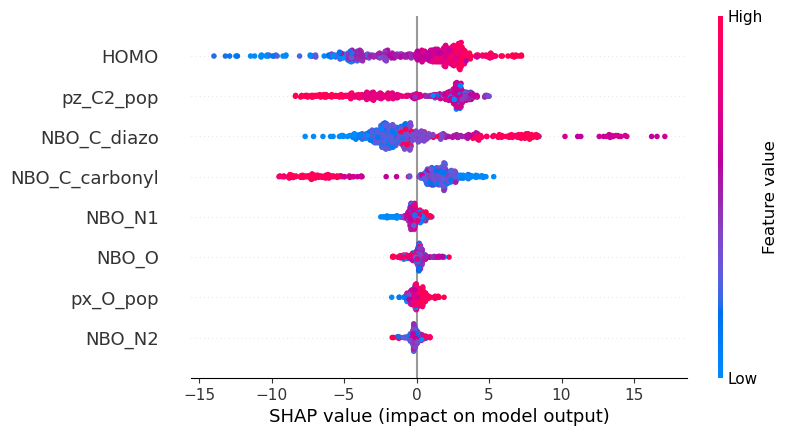

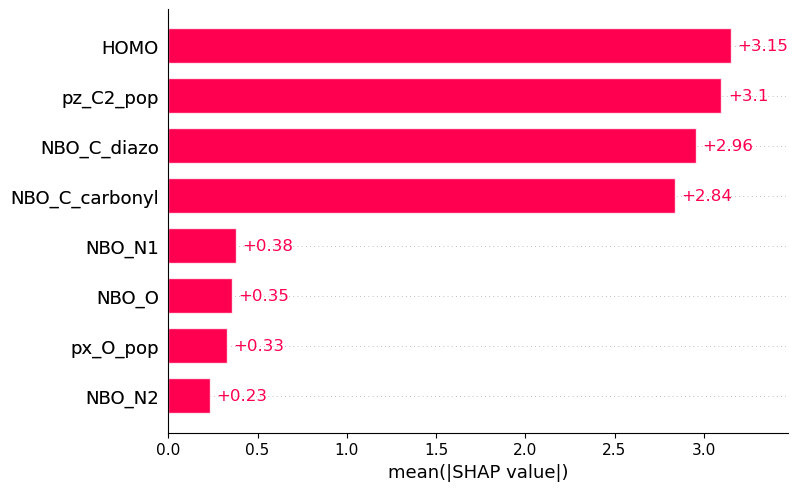

In [15]:
features = X.columns
#print('Features ', features[:])
featureNames=[]
for i in range(0,len(features)-1): 
    featureNames.append(features[i])
nFeatures=len(featureNames)
print('Feature Names ', featureNames)

#shapreg=model     # the used model, here RF
Xs = X  # data2   # this have the headers SHAP
print('\n shap base_values ',shap_values.base_values[0])
base=shap_values.base_values[0]
shap.plots.beeswarm(shap_values,max_display=15) # ,feature_names=featureNames)
shap.plots.bar(shap_values) # ,feature_names=featureNames) # all shap values

# shap.plots.waterfall(shap_values[5])


# what are the most important descriptors? How many there are? list them to top_features. 

# Redo the analysis with this reduced descriptor set. How much the results chenge. (or fourse do first the full set.)  Observe the R2 and MAE values.

In [16]:
features
top_features=['HOMO','NBO_C_diazo','pz_C2_pop','NBO_C_carbonyl']
print(top_features)

['HOMO', 'NBO_C_diazo', 'pz_C2_pop', 'NBO_C_carbonyl']


In [17]:
print(' =========    SHAP 2 ANALYSIS START ========')
shap2_values = shap.TreeExplainer(smodel).shap_values(X)  # this is slow  X for train data, X2 for all 
print(' =========    SHAP 2 ANALYSIS DONE ========')

 =========    SHAP 2 ANALYSIS START ========
 =========    SHAP 2 ANALYSIS DONE ========


 =========    SHAP DEPENDENCE  =============


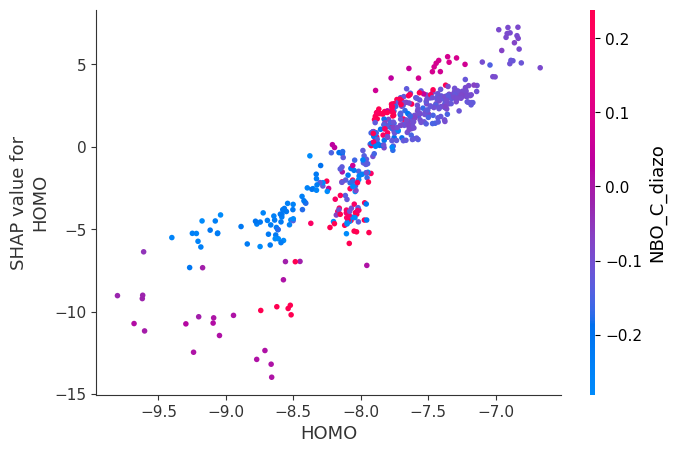

In [20]:

F1="HOMO"
F2='NBO_C_diazo'

print(' =========    SHAP DEPENDENCE  =============')
shap.dependence_plot(F1, shap2_values, X)
#shap.dependence_plot(F2, shap2_values, X)


# Traditional prediction analysis

 shape y (483,) shape X (483, 8)

------------Test large deviations --(cut > 5.0 )-------------
Pred E  5.412173076923082  E_DFT 15.57 diff 10.157826923076918
Pred E  20.35622307692306  E_DFT 27.47 diff 7.113776923076937
Pred E  -27.03652216117215  E_DFT -32.68 diff 5.643477838827849
Pred E  11.222195421245416  E_DFT 16.56 diff 5.337804578754582
Pred E  9.741696153846151  E_DFT 16.01 diff 6.2683038461538505
Pred E  -11.53285970695971  E_DFT -18.22 diff 6.687140293040288
Pred E  1.8731782051282038  E_DFT -3.65 diff 5.523178205128204
Pred E  -10.904745604395615  E_DFT -15.94 diff 5.035254395604385
Pred E  -3.9434499999999924  E_DFT -9.78 diff 5.836550000000007
Pred E  -12.830518589743583  E_DFT -19.85 diff 7.019481410256418
Pred E  7.3114102564102685  E_DFT 15.22 diff 7.908589743589732
Pred E  -24.543995238095228  E_DFT -31.36 diff 6.816004761904772
---------------------------------------------------------------

 R^2 on ML training set: 0.9771906835430301
 MSE on ML training set: 2.8540

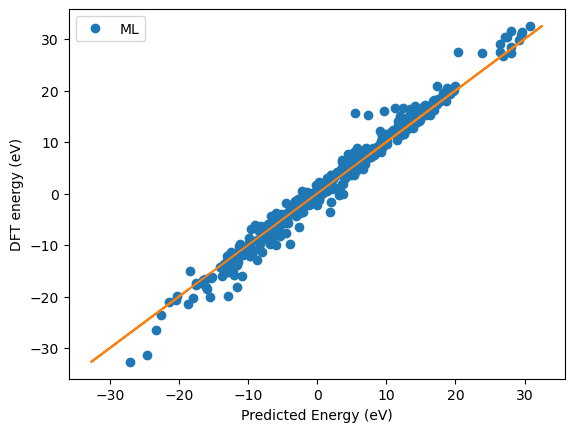

In [19]:
pred_y = model.predict(X)
#print(' shape y',np.shape(y),'shape X',np.shape(X))
yy=[]   # y is suffled  yy contain the unsuffled data
i=0
for yp in y:
#  print('test y  ',i,yp)
  yy.append(yp)
  i+=1
#print('y(0:18) \n',y[0:8],yy[0:8])
print(' shape y',np.shape(y),'shape X',np.shape(X))

cut=5.
print('\n------------Test large deviations --(cut >',cut,')-------------')
for ii in range(len(y)):
    if abs(pred_y[ii]-yy[ii]) > cut:
#      print('Xii, i',ii,X[ii,:])
#       Xtest=X[ii,:].reshape(1, -1) 
#       model.predict(Xtest)
      print('Pred E ',pred_y[ii],' E_DFT',yy[ii],'diff',abs(pred_y[ii]-yy[ii]))

print('---------------------------------------------------------------')
#Xtest=testd.to_numpy()
#for i in range(len(Xtest)):
#  Xtt=Xtest[i,:].reshape(1, -1)
#  print('test ',i,Xtest[i,:])
#  print('Test E',float(model.predict(Xtt)))

plt.plot(pred_y, y, 'o', label = "ML")
plt.plot(y, y)
plt.xlabel("Predicted Energy (eV)")
plt.ylabel("DFT energy (eV)")
plt.legend()
r_sqrt = r2_score(y, pred_y)
e_mse = mse(y,pred_y)  # Mean squared error 
e_mae = mae(y,pred_y)  # Mean abs error 
print("\n R^2 on ML training set:", r_sqrt)
print(" MSE on ML training set:", e_mse)
print(" MAE on ML training set:", e_mae)
#print(r"R^2 on BEP training set:", r_BEP)